C:\Users\AlbinXavier\AppData\Local\Temp\ipykernel_31200\1436654037.py:7: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  ivs = pd.read_csv("../datasets/visitor_survey.csv", parse_dates=["date"])
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\AlbinXavier\AppData\Local\Temp\ipykernel_31200\1436654037.py:64: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  fc_idx   = pd.date_range(fc_start, periods=steps_all, freq="Q")


[SARIMAX (no exog)] AIC: 115.822

[SARIMAX (no exog)] Hold-out accuracy
   RMSE   : 946.965
   MAE    : 946.965
   MAPE%  : 19.213
   sMAPE% : 21.255

Forecast results saved to: ../output/Model_03_SARIMAX_IVS_AvgSpend.csv


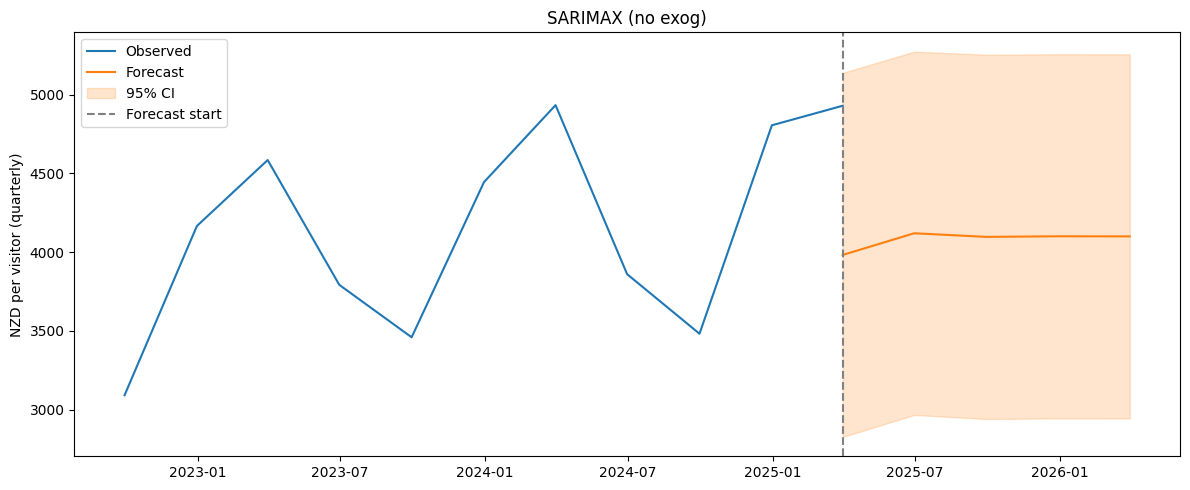

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ============== Data ==============
ivs = pd.read_csv("../datasets/visitor_survey.csv", parse_dates=["date"])

ivs["treated_spend"]  = pd.to_numeric(ivs["treated_spend"], errors="coerce")
ivs["vem_pop_weight"] = pd.to_numeric(ivs["vem_pop_weight"], errors="coerce")

ivs_q = (
    ivs.groupby("date")[["treated_spend", "vem_pop_weight"]]
    .apply(lambda g: np.average(g["treated_spend"], weights=g["vem_pop_weight"]))
    .reset_index(name="avg_spend")
).set_index("date").sort_index()

# (No NZ-resident traveller dataset; no exog)
df = ivs_q.dropna()
y = df["avg_spend"]

# ============== Metrics ==============
def _metrics(y_true: pd.Series, y_pred: pd.Series):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    a, f = y_true.values.astype(float), y_pred.values.astype(float)

    rmse = np.sqrt(np.mean((f - a) ** 2))
    mae  = np.mean(np.abs(f - a))
    mape = np.mean(np.abs((f[a!=0] - a[a!=0]) / a[a!=0])) * 100 if (a!=0).any() else np.nan

    denom = (np.abs(a) + np.abs(f))
    mask  = denom != 0
    smape = (2.0 * np.mean(np.abs(f[mask] - a[mask]) / denom[mask])) * 100.0 if mask.any() else np.nan
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape, "sMAPE%": smape}

def _print_metrics(title: str, m: dict):
    print(f"\n[{title}] Hold-out accuracy")
    for k, v in m.items():
        print(f"   {k:7}: {v:,.3f}" if np.isfinite(v) else f"   {k:7}: nan")

# ============== SARIMAX Forecast (no exog) ==============
def sarimax_forecast(y,
                     order=(1,1,1), seas=(0,0,0,0),
                     k_test=4, h_future=8,
                     title="SARIMAX (no exog)"):

    # --- Split
    y_train, y_test = y.iloc[:-k_test], y.iloc[-k_test:]

    # --- Fit on train only
    model = SARIMAX(
        y_train, order=order, seasonal_order=seas,
        enforce_stationarity=False, enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # --- Print AIC
    print(f"[{title}] AIC: {res.aic:.3f}")

    # --- Forecast for test + future (no exog needed)
    steps_all = k_test + h_future
    # Index spanning test + future, starting at first test quarter-end
    fc_start = y_test.index[0]
    fc_idx   = pd.date_range(fc_start, periods=steps_all, freq="Q")

    fc = res.get_forecast(steps=steps_all)
    y_pred_all = fc.predicted_mean
    ci_all     = fc.conf_int()

    # Align forecast with our explicit index
    y_pred_all.index = fc_idx
    ci_all.index     = fc_idx

    # --- Metrics only on test overlap
    y_pred_test = y_pred_all.iloc[:k_test]
    metrics = _metrics(y_test, y_pred_test)
    _print_metrics(title, metrics)

    # --- Save forecast results (test + future)
    out = pd.DataFrame({
        "Forecast": y_pred_all,
        "LowerCI": ci_all.iloc[:, 0],
        "UpperCI": ci_all.iloc[:, 1],
    })
    out.index.name = "Date"
    out_csv = "../output/Model_03_SARIMAX_IVS_AvgSpend.csv"
    out.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # --- Plot with visible overlap
    plt.figure(figsize=(12,5))
    plt.plot(y.index, y, label="Observed", color="tab:blue")
    plt.plot(y_pred_all.index, y_pred_all, label="Forecast", color="tab:orange")
    plt.fill_between(ci_all.index, ci_all.iloc[:,0], ci_all.iloc[:,1],
                     color="tab:orange", alpha=0.2, label="95% CI")
    plt.axvline(y_test.index[0], color="gray", linestyle="--", label="Forecast start")

    plt.title(title)
    plt.ylabel("NZD per visitor (quarterly)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============== Run ==============
sarimax_forecast(
    y,
    order=(1,1,1), seas=(0,0,0,0),   # adjust seasonal part if needed, e.g., (1,1,1,4) for quarterly
    k_test=min(4, max(1, len(y)//6)),
    h_future=4,
    title="SARIMAX (no exog)"
)
